# Project 4 - QR Code Reader

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [learning suite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below.

Please also fill in here the time that each part took you:
* 1. Part A: <span style="color:red;">~2 hours</span>
* 2. Part B: <span style="color:red;">~2 hours</span>
* 3. Part C: <span style="color:red;">~6 hours</span>
* 4. Tests: <span style="color:red;">~30 mins</span>
* 5. Challenge 1: <span style="color:red;">~30 mins for challenge 3</span>
* 6. Challenge 2: <span style="color:red;">FILL IN TIME</span>
* 7. Write-up: <span style="color:red;">~15 mins</span>

### Understanding QR Codes

QR codes (short for Quick Response Codes) were invented in 1994, by the DENSO Corporation. These codes store data in two dimensions in the form of an array of contrasting regions. The information density of a QR code is much higher than a vanilla barcode; depending on the format used and the resolution of reader, over a thousand bytes can be encoded in a region the size of a postage stamp.

QR codes use a Reed–Solomon error correction based technology to help recover from errors in reading (for instance, caused by a smudge, badly printed code or other deformity).

Any QR code can be broken into the following sections:

<div style="width:75%;text-align:center;"><img src="Images/formatting.jpg" width=100%></div>

On three corners of a QR code are square blocks that the reader uses to coarsely identify and then align the code. These will be of primary interest during the lab. Once these corners are identified and the image is aligned, the size of the QR code is determined by the timing information which alternates from black and white in both the vertical and horizontal direction. 

Once the image is aligned and the size determined, the QR code is discretized, undergoes an Xor with a particular mask given the format information, and read bit for bit in the following order:

<div style="width:75%;text-align:center;"><img src="Images/decoding.jpg" width=100%></div>

For more details about the decoding process, see the [DataGenetics Wounded QR Codes Blog](http://datagenetics.com/blog/november12013/index.html).

For this lab, we will focus primarily the computer vision side of QR codes, which involves detecting, aligning, and discretizing QR codes so that they can be read properly.

In [1]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

### Part A: Finding Corners

QR codes are designed with a very specific pattern so that can efficiently be detected, oriented, and decoded. The first step to detecting a QR code is finding the position markers that are always present in three of the four corners. These position markers always have a black/white/black/white/black ratio of 1:1:3:1:1, no matter the angle they are approached from.

<div style="width:20%;text-align:center;"><img src="Images/finder_pattern.jpg" width=100%></div>

Preprocess your image by thresholding to black and white. Scan across rows of the image, marking locations that have the 1:1:3:1:1 ratio (note: this is most easily done by keeping multiple counters for black and white pixels).

<div style="width:20%;text-align:center;"><img src="Images/first_scan.jpg" width=100%></div>

Once you have candidate locations, verify the locations by also scanning vertically, diagonally and in other directions. Also complete a non maximal suppression to get your final three candidate points.

<div style="width:20%;text-align:center;"><img src="Images/candidates.JPG" width=100%></div>

In [2]:
def find_corners_TB(image, THRESHOLD):
    corner_width = 0
    width, height = image.shape
    corners = np.zeros((width, height))
    # need to check ratio to verify the ratio is correct.
    for row in range(len(image)):
        blackL_cnt = 0 # 1
        whiteL_cnt = 0 # 1
        blackM_cnt = 0 # 3
        whiteR_cnt = 0 # 1
        blackR_cnt = 0 # 1
        collectedYX = []
        for col in range(len(image[row])):
            if blackR_cnt != 0 and abs(blackL_cnt-whiteL_cnt)<THRESHOLD and abs(whiteL_cnt-whiteR_cnt)<THRESHOLD and abs(whiteR_cnt-blackR_cnt)<THRESHOLD and abs(blackL_cnt * 3-blackM_cnt)<THRESHOLD:
                if corner_width == 0:
                    corner_width = corner_width = blackL_cnt + whiteL_cnt + blackM_cnt + whiteR_cnt + blackR_cnt
                else:
                    corner_width += blackL_cnt + whiteL_cnt + blackM_cnt + whiteR_cnt + blackR_cnt
                    corner_width = corner_width / 2
                
                #print(collectedYX)
                collectedYX = sorted(collectedYX, key=lambda x: x[1], reverse=True)
                #print(collectedYX)
                y, x = collectedYX[len(collectedYX)//2]
                #for points in collectedYX:
                corners[y, x] = 255.0

                #for points in collectedYX:
                    #corners[points[0], points[1]] = 255.0
                    
                blackL_cnt = 0 # 1
                whiteL_cnt = 0 # 1
                blackM_cnt = 0 # 3
                whiteR_cnt = 0 # 1
                blackR_cnt = 0 # 1
                collectedYX = []
            # if the pixel is black
            if image[row,col] == 0: 
                # no left white pixels seen, increase black
                if whiteL_cnt == 0:
                    blackL_cnt += 1
                elif whiteR_cnt == 0:
                    if blackL_cnt > whiteL_cnt:
                        blackL_cnt = 1 # 1
                        whiteL_cnt = 0 # 1
                        blackM_cnt = 0 # 3
                        whiteR_cnt = 0 # 1
                        blackR_cnt = 0 # 1
                        collectedYX = []
                    else:
                        blackM_cnt += 1
                        # set potential mid
                        collectedYX.append([row, col])
                else:
                    blackR_cnt += 1
            # if the pixel is white
            else: 
                if blackL_cnt < whiteL_cnt:
                    blackL_cnt = 0 # 1
                    whiteL_cnt = 0 # 1
                    blackM_cnt = 0 # 3
                    whiteR_cnt = 0 # 1
                    blackR_cnt = 0 # 1
                    collectedYX = []
                if blackM_cnt == blackL_cnt:
                    blackL_cnt = blackM_cnt # 1
                    #whiteL_cnt = 0 # 1
                    blackM_cnt = 0 # 3
                    whiteR_cnt = 0 # 1
                    blackR_cnt = 0 # 1
                    collectedYX = []
                # if left black pixels have been seen, but no middle ones
                if blackL_cnt > 0 and blackM_cnt == 0:
                    whiteL_cnt += 1
                elif blackM_cnt > 0 and blackR_cnt == 0:
                    whiteR_cnt += 1
                else:
                    blackL_cnt = 0 # 1
                    whiteL_cnt = 0 # 1
                    blackM_cnt = 0 # 3
                    whiteR_cnt = 0 # 1
                    blackR_cnt = 0 # 1
                    collectedYX = []
    return corners, corner_width

In [3]:
def find_corners_LR(image, THRESHOLD):
    corner_width = 0
    width, height = image.shape
    corners = np.zeros((width, height))
    for col in range(len(image[0])):
        blackL_cnt = 0 # 1
        whiteL_cnt = 0 # 1
        blackM_cnt = 0 # 3
        whiteR_cnt = 0 # 1
        blackR_cnt = 0 # 1
        collectedYX = []
        for row in range(len(image)):
            if blackR_cnt != 0 and abs(blackL_cnt-whiteL_cnt)<THRESHOLD and abs(whiteL_cnt-whiteR_cnt)<THRESHOLD and abs(whiteR_cnt-blackR_cnt)<THRESHOLD and abs(blackL_cnt*3 - blackM_cnt)<THRESHOLD:
                if corner_width == 0 :
                    corner_width = blackL_cnt + whiteL_cnt + blackM_cnt + whiteR_cnt + blackR_cnt
                else:
                    corner_width += blackL_cnt + whiteL_cnt + blackM_cnt + whiteR_cnt + blackR_cnt
                    corner_width = corner_width / 2
                #print(collectedYX)
                collectedYX = sorted(collectedYX, key=lambda x: x[1], reverse=True)
                #print(collectedYX)
                y, x = collectedYX[len(collectedYX)//2]
                #for points in collectedYX:
                corners[y, x] = 255.0

                #for points in collectedYX:
                    #corners[points[0], points[1]] = 255.0
                    
                blackL_cnt = 0 # 1
                whiteL_cnt = 0 # 1
                blackM_cnt = 0 # 3
                whiteR_cnt = 0 # 1
                blackR_cnt = 0 # 1
                collectedYX = []
            # if the pixel is black
            if image[row,col] == 0: 
                # no left white pixels seen, increase black
                if whiteL_cnt == 0:
                    blackL_cnt += 1
                elif whiteR_cnt == 0:
                    if blackL_cnt > whiteL_cnt:
                        blackL_cnt = 1 # 1
                        whiteL_cnt = 0 # 1
                        blackM_cnt = 0 # 3
                        whiteR_cnt = 0 # 1
                        blackR_cnt = 0 # 1
                        collectedYX = []
                    else:
                        blackM_cnt += 1
                        # set potential mid
                        collectedYX.append([row, col])
                else:
                    blackR_cnt += 1
            # if the pixel is white
            else: 
                if blackL_cnt < whiteL_cnt:
                    blackL_cnt = 0 # 1
                    whiteL_cnt = 0 # 1
                    blackM_cnt = 0 # 3
                    whiteR_cnt = 0 # 1
                    blackR_cnt = 0 # 1
                    collectedYX = []
                if blackM_cnt == blackL_cnt:
                    blackL_cnt = blackM_cnt # 1
                    #whiteL_cnt = 0 # 1
                    blackM_cnt = 0 # 3
                    whiteR_cnt = 0 # 1
                    blackR_cnt = 0 # 1
                    collectedYX = []
                # if left black pixels have been seen, but no middle ones
                if blackL_cnt > 0 and blackM_cnt == 0:
                    whiteL_cnt += 1
                elif blackM_cnt > 0 and blackR_cnt == 0:
                    whiteR_cnt += 1
                else:
                    blackL_cnt = 0 # 1
                    whiteL_cnt = 0 # 1
                    blackM_cnt = 0 # 3
                    whiteR_cnt = 0 # 1
                    blackR_cnt = 0 # 1
                    collectedYX = []
    return corners, corner_width
    

In [17]:
# Your Code Here
# load images
image1 = cv2.imread('./QR_codes/test1.png')
image2 = cv2.imread('./QR_codes/test2.png')
image3 = cv2.imread('./QR_codes/test3.png')
image4 = cv2.imread('./QR_codes/test4.png')
image5 = cv2.imread('./QR_codes/test5.png')
challenge1 = cv2.imread('./QR_codes/challenge1.png')
challenge2 = cv2.imread('./QR_codes/challenge2.png')
challenge3 = cv2.imread('./QR_codes/challenge3.png')

image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2GRAY)
image4 = cv2.cvtColor(image4, cv2.COLOR_BGR2GRAY)
image5 = cv2.cvtColor(image5, cv2.COLOR_BGR2GRAY)
challenge1 = cv2.cvtColor(challenge1, cv2.COLOR_BGR2GRAY)
challenge2 = cv2.cvtColor(challenge2, cv2.COLOR_BGR2GRAY)
challenge3 = cv2.cvtColor(challenge3, cv2.COLOR_BGR2GRAY)

# blur image slightly in case of noise
#image1 = cv2.blur(image1, (3,3))
image2 = cv2.blur(image2, (3,3))
#image3 = cv2.blur(image3, (3,3))
#image4 = cv2.blur(image4, (3,3))
#image5 = cv2.blur(image5, (3,3))
# threshold the images to black and white

#kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
#challenge4 = cv2.filter2D(src=challenge4, ddepth=-4, kernel=kernel)


THRESHOLD = 128
image1 = cv2.threshold(image1, THRESHOLD, 255, cv2.THRESH_BINARY)[1]
image2 = cv2.threshold(image2, THRESHOLD, 255, cv2.THRESH_BINARY)[1]
image3 = cv2.threshold(image3, THRESHOLD, 255, cv2.THRESH_BINARY)[1]
image4 = cv2.threshold(image4, THRESHOLD, 255, cv2.THRESH_BINARY)[1]
image5 = cv2.threshold(image5, THRESHOLD, 255, cv2.THRESH_BINARY)[1]
challenge1 = cv2.threshold(challenge1, THRESHOLD, 255, cv2.THRESH_BINARY)[1]
challenge2 = cv2.threshold(challenge2, THRESHOLD, 255, cv2.THRESH_BINARY)[1]
challenge3 = cv2.threshold(challenge3, THRESHOLD, 255, cv2.THRESH_BINARY)[1]

SENSITIVITY = 25 # orig 35
print(image1.shape)
corners1, corner_width1 = find_corners_TB(image1, SENSITIVITY)
corners2, corner_width2 = find_corners_TB(image2, SENSITIVITY)
corners3, corner_width3 = find_corners_TB(image3, SENSITIVITY)
corners4, corner_width4 = find_corners_TB(image4, SENSITIVITY)
corners5, corner_width5 = find_corners_TB(image5, SENSITIVITY)
challenge1_corners, challenge1_width = find_corners_TB(challenge1, SENSITIVITY)
challenge2_corners, challenge2_width = find_corners_TB(challenge2, SENSITIVITY)
challenge3_corners, challenge3_width = find_corners_TB(challenge3, SENSITIVITY)

corners12, corner_width12 = find_corners_LR(image1, SENSITIVITY)
corners22, corner_width22 = find_corners_LR(image2, SENSITIVITY)
corners32, corner_width32 = find_corners_LR(image3, SENSITIVITY)
corners42, corner_width42 = find_corners_LR(image4, SENSITIVITY)
corners52, corner_width52 = find_corners_LR(image5, SENSITIVITY)
challenge12_corners, challenge12_width = find_corners_LR(challenge1, SENSITIVITY)
challenge22_corners, challenge22_width = find_corners_LR(challenge2, SENSITIVITY)
challenge32_corners, challenge32_width = find_corners_LR(challenge3, SENSITIVITY)

corners1 += corners12
corners2 += corners22
corners3 += corners32
corners4 += corners42
corners5 += corners52
challenge1_corners += challenge12_corners
challenge2_corners += challenge22_corners
challenge3_corners += challenge32_corners

#corner_widths = (corner_width1 + corner_width2 + corner_width3 + corner_width4 + corner_width5 + corner_width12 + corner_width22 + corner_width32 + corner_width42 + corner_width52)//10
corner_widths = [(corner_width1 + corner_width12)//2, (corner_width2 + corner_width22)//2, (corner_width3 + corner_width32)//2, (corner_width4 + corner_width42)//2, (corner_width5 + corner_width52)//2, (challenge3_width + challenge32_width)//2]

print(corner_widths)
    

(200, 200)
[56.0, 54.0, 53.0, 56.0, 41.0, 51.0]


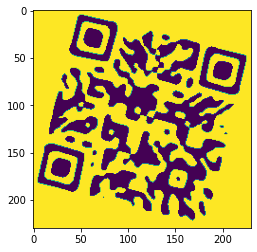

In [18]:
plt.imshow(challenge4)

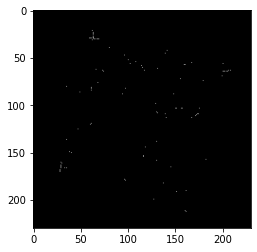

In [19]:
plt.imshow(challenge4_corners, cmap='gray')

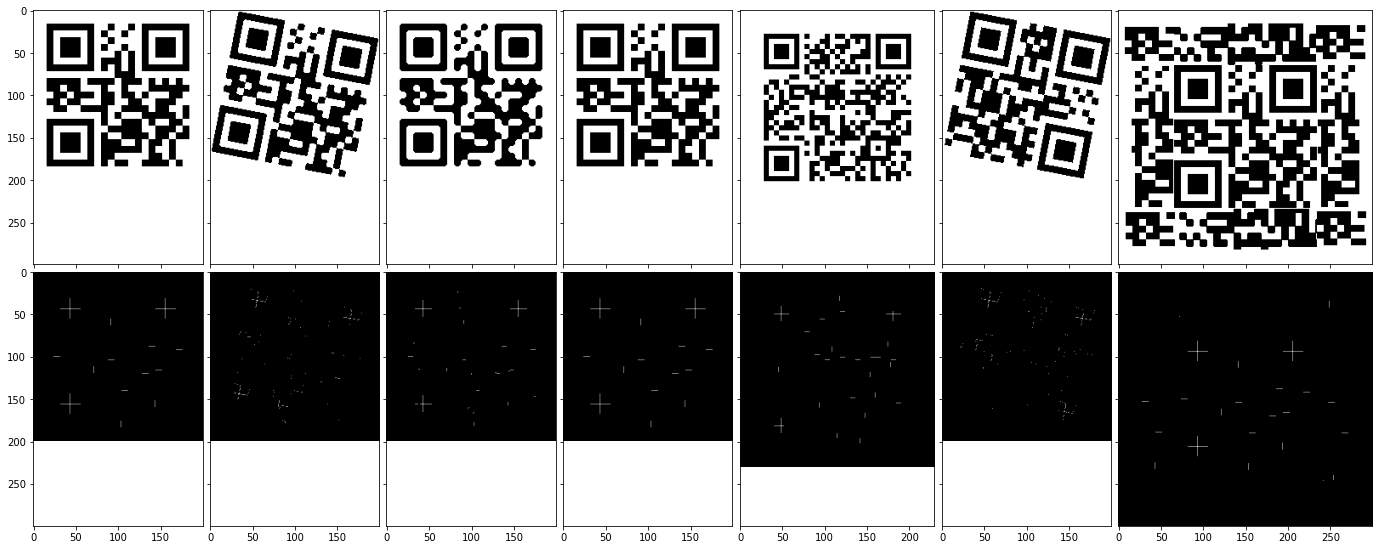

In [20]:
#image1 += corners
fig = plt.figure(figsize=(24., 24.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 7),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, [image1, image2, image3, image4, image5, challenge1, challenge3, corners1, corners2, corners3, corners4, corners5, challenge1_corners, challenge3_corners]):
    ax.imshow(im, cmap='gray')
    #ax.title = "Original"

### Part B: Finding The Fourth Point and Aligning with a Homography

QR codes only contain three known corner points, but homographies require four points to be defined. If the warping present in the image is small enough, an affine transform is generally sufficient to find the fourth point (i.e. the *x,y* coordinate difference between point 1 and point 2 will be the same as the *x,y* coordinate difference between point 3 and point 4). Use this assumption to find the fourth point.

<div style="width:20%;text-align:center;"><img src="Images/four_points.JPG" width=100%></div>

Once you have the four points, generate the homography that would align the QR code with the *x,y* axes. Crop the aligned image until only the QR code is visible.

<div style="width:20%;text-align:center;"><img src="Images/aligned.jpg" width=100%></div>

In [8]:
def k_largest_index_argsort(a, k):
    idx = np.argsort(a.ravel())[:-k-1:-1]
    return np.column_stack(np.unravel_index(idx, a.shape))

In [9]:
def find_fourth_corner(corners):
    # sort points top to bottom
    corners = corners[corners[:,0].argsort()]
    TB_difference = np.abs(corners[0] - corners[2])[0]
    LR_difference = np.abs(corners[1] - corners[0])[1]
    
    #print(TB_difference)
    #print(LR_difference)
    
    return [corners[1,0] + TB_difference, corners[2,1] + LR_difference]

In [10]:
def calculate_newimage_size(corners):
    temp_corners = corners[corners[:,0].argsort()]
    newimage_width = abs(temp_corners[0,1] - temp_corners[1,1]) + 32
    newimage_height = abs(temp_corners[0,0] - temp_corners[2,0]) + 32
    return newimage_height, newimage_width
    #print(newimage_height, newimage_width)

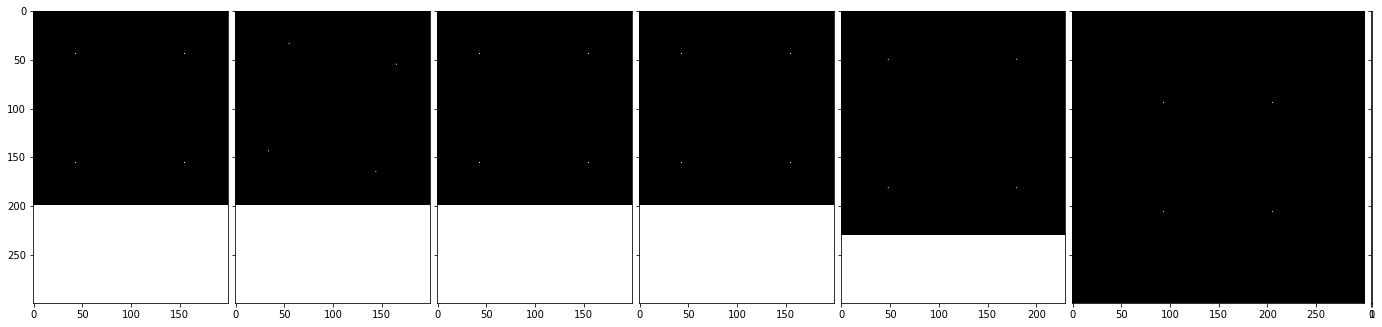

In [21]:
# Your Code Here
# grab 3 corner points
image1_corners = k_largest_index_argsort(corners1, 3)
image2_corners = k_largest_index_argsort(corners2, 3)
image3_corners = k_largest_index_argsort(corners3, 3)
image4_corners = k_largest_index_argsort(corners4, 3)
image5_corners = k_largest_index_argsort(corners5, 3)
challenge1_corners = k_largest_index_argsort(challenge1_corners, 3)
challenge3_corners = k_largest_index_argsort(challenge3_corners, 3)



final_point = find_fourth_corner(image1_corners)
image1_corners = np.append(image1_corners,[final_point], axis=0)
final_point = find_fourth_corner(image2_corners)
image2_corners = np.append(image2_corners,[final_point], axis=0)
final_point = find_fourth_corner(image3_corners)
image3_corners = np.append(image3_corners,[final_point], axis=0)
final_point = find_fourth_corner(image4_corners)
image4_corners = np.append(image4_corners,[final_point], axis=0)
final_point = find_fourth_corner(image5_corners)
image5_corners = np.append(image5_corners,[final_point], axis=0)
final_point = find_fourth_corner(challenge1_corners)
challenge1_corners = np.append(challenge1_corners, [final_point], axis=0)
final_point = find_fourth_corner(challenge3_corners)
challenge3_corners = np.append(challenge3_corners, [final_point], axis=0)


corners_list = [image1_corners, image2_corners, image3_corners, image4_corners, image5_corners, challenge3_corners]
image_list = [image1, image2, image3, image4, image5, challenge3]
final_corners = []
for corners, image in zip(corners_list, image_list):
    height, width = image.shape
    array = np.zeros((height, width))
    for corner in corners:
        array[corner[0], corner[1]] = 255.0
    final_corners.append(array)


fig = plt.figure(figsize=(24., 24.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 7),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, final_corners):
    ax.imshow(im, cmap='gray')
    

In [23]:
def createMatrix(points, homog_points):
    #print(points)
    #print(homog_points)
    temp_points = points[np.lexsort((points[:,1], points[:, 0]))]
    temp_homog_points = homog_points[np.lexsort((homog_points[:,1], homog_points[:,0]))]
    #print(temp_points)
    #print(temp_homog_points)
    A = np.zeros((2*len(temp_points), 8))
    idx = 0
    
    for point in range(len(temp_points)):
        x1 = temp_points[point][1]
        y1 = temp_points[point][0]
        xp1 = temp_homog_points[point][1]
        yp1 = temp_homog_points[point][0]
        A[idx] = x1,y1,1.0,0.0,0.0,0.0,-1*xp1*x1,-1*xp1*y1
        idx += 1
        A[idx] = 0.0,0.0,0.0,x1,y1,1.0,-1*yp1*x1,-1*yp1*y1
        idx += 1
    return A

In [24]:
def createPrime(points):
    prime = []
    for point in points:
        prime.append([point[1]])
        prime.append([point[0]])
    return prime

In [25]:
def createHomography(image_corners, corner_width):
    new_height, new_width = calculate_newimage_size(image_corners)
    if corner_width > 48:
        corner_width = 46
    #homogTL = np.array([28,27])
    #homogTL = np.array([corner_width, corner_width])
    #homog_corners = np.array([list(homogTL), list(homogTL+[0, new_width]), list(homogTL + [new_height,0]), list(homogTL + [new_height, new_width])])
    print(corner_width)
    print(new_height, new_width)
    RATIO = 1.8
    BASERATIO = 2
    homog_corners = np.array([[corner_width/BASERATIO,corner_width/BASERATIO],[corner_width/BASERATIO,new_width-corner_width/RATIO],[new_height-corner_width/RATIO,corner_width/BASERATIO],[new_height-corner_width/RATIO,new_width-corner_width/RATIO]])
    #print(homog_corners)
    A = createMatrix(image_corners, homog_corners)
    prime = createPrime(homog_corners)
    #print(prime)

    homography = np.linalg.lstsq(A, prime)[0]
    homography3x3 = np.append(homography, [[1]], axis=0).reshape(3,3)
    #print(homography3x3)
    return homography3x3, new_height, new_width, corner_width

In [26]:
def transform_image(image, image_corners, corner_width):
    homo, new_height, new_width, corner_width = createHomography(image_corners, corner_width)
    #corner_width = 72
    dx = 1
    dy = 1
    #print(homo)
    transform = np.matmul([[1,0,dx],[0,1,dy],[0,0,1]], homo)

    #print(transform)
    combined = cv2.warpPerspective(image, transform, (new_height, new_width))
    return combined, corner_width

46
144 144
46
142 142
46
144 144
46
144 144
41.0
164 164
46
144 144


<ipython-input-25-8ab2a2db84bf>:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  homography = np.linalg.lstsq(A, prime)[0]


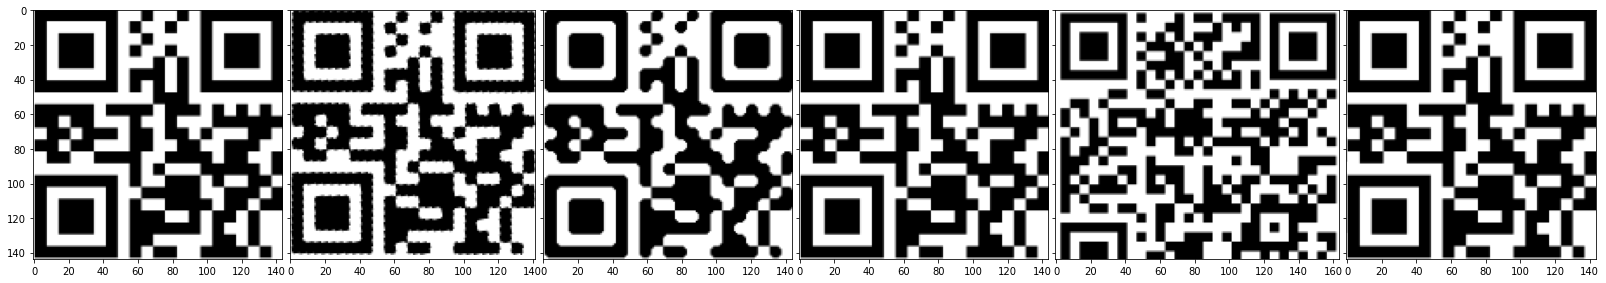

In [27]:
new_images = []
the_images = [image1, image2, image3, image4, image5, challenge3]
the_corners = [image1_corners, image2_corners, image3_corners, image4_corners, image5_corners, challenge3_corners]
new_corner_widths = []
for pos in range(6):
    newimg, corner_width = transform_image(the_images[pos], the_corners[pos], corner_widths[pos])
    new_images.append(newimg)
    new_corner_widths.append(corner_width)

fig = plt.figure(figsize=(28., 28.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 6),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, new_images):
    ax.imshow(im, cmap='gray')

plt.imshow()

### Part C: Discretization

Now that the image is aligned, the QR code needs to discretized so that each block is a single bit, rather than a group of pixels. The simplest way to do this is to count the number of black and white pixels in a region and assign the block to the highest count. However, to do this, the size of the QR code needs to be determined. All QR codes have an odd number of bits per row and column, starting at size 21 and incrementing by 4 (i.e. 21x21, 25x25, 29x29, ...). For this lab, you will only need to check for sizes from 21 to 33.

To check if a QR code matches a given size, discretize the QR code asumming the given size. Then, determine if the timing information alternates in the appropriate manner (see the Understanding QR Codes for more information). If the timing information is valid, then you can assume that the QR code is the given size.

Once you have the correct size, discretize the QR code accordingly and return a Numpy array of True/False values.


In [28]:
def get_corner_width(image):
    topRow = image[3,:]
    width = 0
    for col in topRow:
        if col == 0:
            width += 1
        elif width < 5:
            continue
        else:
            break
    return round(width / 7)
    #return int(width / 7)


In [29]:
def get_image_bit_width(image, pxlwidth):
    height, width = image.shape
    THRESHOLD = 5
    if abs((height / pxlwidth) - 21) < THRESHOLD:
        if check_timing(image, pxlwidth, 21):
            return 21
        return 0
    if abs((height / pxlwidth) - 25) < THRESHOLD:
        if check_timing(image, pxlwidth, 25):
            return 25
        return 0
    if abs((height / pxlwidth) - 29) < THRESHOLD:
        if check_timing(image, pxlwidth, 29):
            return 29
        return 0
    if abs((height / pxlwidth) - 33) < THRESHOLD:
        if check_timing(image, pxlwidth, 33):
            return 33
        return 0
    #print(height / pxlwidth)

In [30]:
def get_pixel_value(values):
    values_cpy = values.flatten()
    return np.bincount(values_cpy).argmax()


In [31]:
def check_timing(image, pxlwidth, size):
    #print(image.shape)
    #print(pxlwidth)
    horizontal_timing = image[pxlwidth*6:pxlwidth*7,pxlwidth*8:pxlwidth*(size-8)] # 7-22 for 29
    vertical_timing = image[pxlwidth*8:pxlwidth*(size-8),pxlwidth*6:pxlwidth*7] # 7-22 for 29
    matchH = True

    prev_temp = 1
    for pos in range(len(horizontal_timing), pxlwidth):
        temp1 = horizontal_timing[:,pos:pos+pxlwidth]
        temp1 = get_pixel_value(temp1)
        if temp1 != prev_temp:
            prev_temp = temp1
        else:
            print("HORZ TIMING DIDN\'T MATCH!")
            matchH = False
            break

    matchV = True
    prev_temp = 1
    for pos in range(len(vertical_timing), pxlwidth):
        temp1 = vertical_timing[pos:pos+pxlwidth,:]
        temp1 = get_pixel_value(temp1)
        if temp1 != prev_temp:
            prev_temp = temp1
        else:
            print("VERT TIMING DIDN\'T MATCH!")
            matchV = False
            break
        
    if matchH and matchV:
        return True
        #print('match')
    else:
        return False


In [32]:
def discretisize(image, size):
    return_array = np.zeros((size,size))
    
    pxlsize = get_corner_width(image)
    for row in range(size):
        for col in range(size):
            if pxlsize > 6:
                HELPX = -3 #-2
                HELPY = -3 #-3
                if row < 7:
                    HELPY = 1 #0
                if col < 6:
                    HELPX = 1 #0
                values = image[(row*pxlsize)+HELPY:(row*pxlsize)+pxlsize+HELPY, (col*pxlsize)+HELPX:col*pxlsize+pxlsize+HELPX]
            else:
                HELPX = 15
                HELPY = 15
                if row < 21:
                    HELPY = 10
                if row < 16:
                    HELPY = 8
                if row < 8:
                    HELPY = 4
                if col < 21:
                    HELPX = 11
                if col < 16:
                    HELPX = 9
                if col < 8:
                    HELPX = 5

                values = image[(row*pxlsize)+HELPY:(row*pxlsize)+pxlsize+HELPY, (col*pxlsize)+HELPX:col*pxlsize+pxlsize+HELPX]
           
            
            return_array[row, col] = get_pixel_value(values)

            prev_val = get_pixel_value(values)

    return return_array

In [33]:
# Your Code Here
aligned1 = new_images[0]
aligned2 = new_images[1]
aligned3 = new_images[2]
aligned4 = new_images[3]
aligned5 = new_images[4]
challenge3_aligned = new_images[5]

size1 = get_image_bit_width(aligned1, get_corner_width(aligned1))
size2 = get_image_bit_width(aligned2, get_corner_width(aligned2))
size3 = get_image_bit_width(aligned3, get_corner_width(aligned3))
size4 = get_image_bit_width(aligned4, get_corner_width(aligned4))
size5 = get_image_bit_width(aligned5, get_corner_width(aligned5))
challenge3_size = get_image_bit_width(challenge3_aligned, get_corner_width(challenge3_aligned))
print("Pixel sizes:", get_corner_width(aligned1),get_corner_width(aligned2),get_corner_width(aligned3),get_corner_width(aligned4),get_corner_width(aligned5),get_corner_width(challenge3_aligned))
print("Bit h/w: ", size1, size2, size3, size4, size5,challenge3_size)

discret1 = discretisize(aligned1, size1)
discret2 = discretisize(aligned2, size2)
discret3 = discretisize(aligned3, size3)
discret4 = discretisize(aligned4, size4)
discret5 = discretisize(aligned5, size5)
challenge3_discret = discretisize(challenge3_aligned, challenge3_size)
#plt.imshow(discret1)
#print(get_corner_width(aligned5))

Pixel sizes: 7 7 7 7 5 7
Bit h/w:  21 21 21 21 29 21


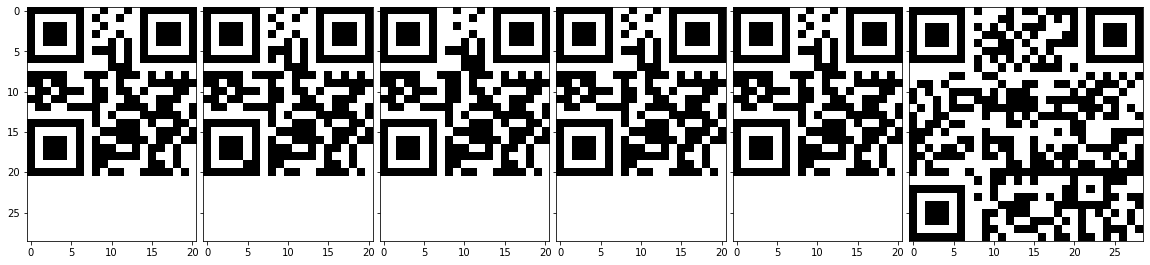

In [34]:
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 6),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, [discret1, discret2, discret3, discret4, challenge3_discret, discret5]):
    ax.imshow(im, cmap='gray')

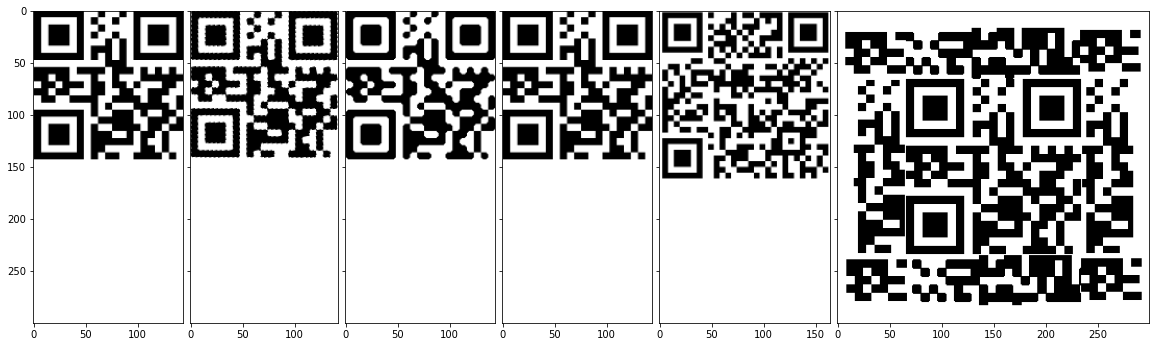

In [35]:
fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 6),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
for ax, im in zip(grid, [aligned1, aligned2, aligned3, aligned4, aligned5, challenge3]):
    ax.imshow(im, cmap='gray')

### Part D: Decoding

QR codes are decoded using a very particular block pattern (see Understanding QR Codes). However, for simplicity, we have implemented this decoder for you. To use it, simply call `decode()` from the decoder.py file and feed it your 2D Numpy array. It will return a string with the QR code data.

**Note: You may need to run** `conda install beautifulsoup4` **and** `conda install requests` **to get the decoder to run.**

In [36]:
# 1, 2, 3, and 4 WORK!!!!
from decoder import decode
output1 = decode(discret1)
print("1: ",output1)
output2 = decode(discret2)
print("2: ",output2)
output3 = decode(discret3)
print("3: ",output3)
output4 = decode(discret4)
print("4: ",output4)
output5 = decode(discret5)
print("5: ", output5)
output_challenge3 = decode(challenge3_discret)
print("Chal3: ", output_challenge3)


1:  http://byu.edu
2:  http://byu.edu
3:  http://byu.edu
4:  http://byu.edu
5:  http://DataGenetics.com
Chal3:  http://byu.edu


## Tests

Once you have your full algorithm working, run your code on the five test images in the *QR_codes* folder. Show your results below.

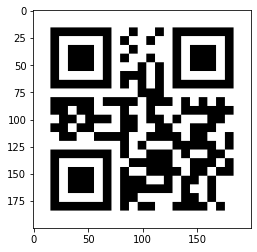

1:  http://byu.edu


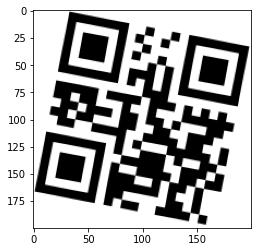

2:  http://byu.edu


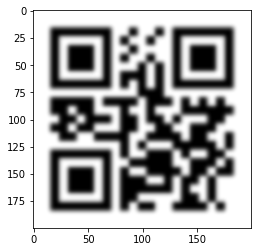

3:  http://byu.edu


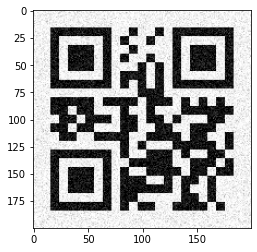

4:  http://byu.edu


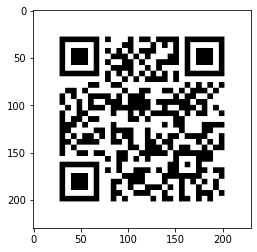

5:  http://DataGenetics.com


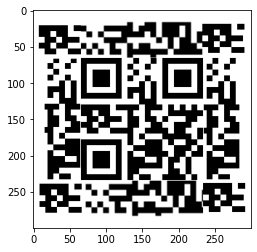

Chal3:  http://byu.edu


In [37]:
image = cv2.imread("QR_codes/test1.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
output1 = decode(discret1)
print("1: ",output1)

image = cv2.imread("QR_codes/test2.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
output2 = decode(discret2)
print("2: ",output2)

image = cv2.imread("QR_codes/test3.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
output3 = decode(discret3)
print("3: ",output3)

image = cv2.imread("QR_codes/test4.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
output4 = decode(discret4)
print("4: ",output4)

image = cv2.imread("QR_codes/test5.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
output5 = decode(discret5)
print("5: ", output5)

image = cv2.imread("QR_codes/challenge3.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()
output_challenge3 = decode(challenge3_discret)
print("Chal3: ", output_challenge3)


## Grading and Challenges
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Code that correctly finds the three corners of the QR code.
* [20 pts] Code that aligns the QR code and crops appropriately.
* [20 pts] Code that correctly discretizes for an arbitrary size.
* [10 pts] For a full algorithm that correctly scans the five test images.

The last 30 points are earned through completing a subset of the following challenges:

* [15 pts] Correctly scan a QR code that is misaligned by more than 90 degrees (e.g. challenge1.png)
* [15 pts] Correctly scan a QR code that is perspective shifted by using the additional alignment square present in larger QR codes. (e.g. challenge2.png)
* [15 pts] Correctly scan a QR code that is surrounded by additional pixels (e.g. challenge3.png)
* [15 pts] Correctly scan a QR code with large amounts of noise and distortion (e.g. challenge4.png)
* [30 pts] Implement a Code 128 1D bar code scanner (e.g. challenge5.png)

You may earn up to 15 points extra credit for additional challenges you complete.



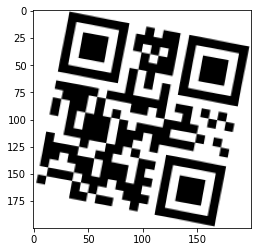

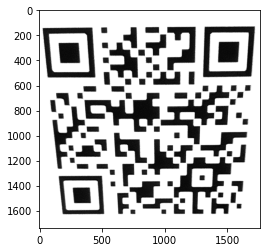

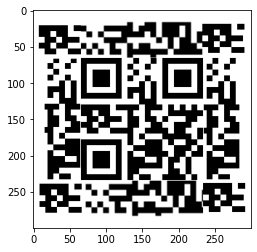

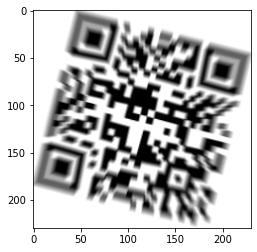

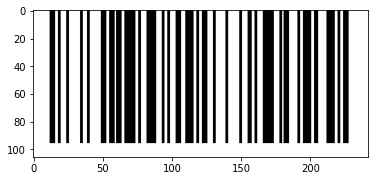

In [52]:
image = cv2.imread("QR_codes/challenge1.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()

image = cv2.imread("QR_codes/challenge2.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()

image = cv2.imread("QR_codes/challenge3.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()

image = cv2.imread("QR_codes/challenge4.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()


image = cv2.imread("QR_codes/challenge5.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap="gray");plt.show()



## Write-up:
Provide an explanation for the following items:
* Which part of this lab did you find most difficult?
* For each challenge completed, explain how you were able to solve the problem presented.
* What improvements would you recommend for this lab?


Your Write-up Here

The discretization was definitely the hardest part of the lab. My stride needed some help in order to properly discretize the QR codes.
Honestly, in order to solve challenge 3 I just made sure that my corner algorithm was strong and robust. Challenge 3 was easier for me than image5 even.

I liked this lab, can't say that I have any improvements. 